# ECoG preprocessing

This tutorial introduces a simple preprocessing pipeline to ready raw ECoG signal from an EDF for further analyses.

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/hassonlab/podcast-ecog-tutorials/blob/main/notebooks/02-preprocessing.ipynb)

In [ ]:
!pip install mne mne_bids

In [1]:
import mne
from mne_bids import BIDSPath

## Download the data

We will demonstrate preprocessing for one subject's raw ECoG data. The data is stored in a common [EDF](https://www.edfplus.info) format which we'll load and process with MNE. The raw data is stored in the dataset's top directory, inside the `ieeg` data type. First, we'll build the appropriate `BIDSPath`.

In [2]:
bids_root = ""  # if using a local dataset, set this variable accordingly

file_path = BIDSPath(root=bids_root,
                    subject="01", task="podcast", datatype="ieeg",
                    suffix="ieeg", extension=".edf")
print(f"File path within the dataset: {file_path}")

# You only need to run this if using Colab (i.e. if you did not set bids_root to a local directory)
if not len(bids_root):
    !wget -nc https://s3.amazonaws.com/openneuro.org/ds005574/$file_path
    file_path = file_path.basename

File path within the dataset: ../../monkey/sub-01/ieeg/sub-01_task-podcast_ieeg.edf


Next, we'll load the data with MNE `read_raw_edf` function:

In [3]:
raw = mne.io.read_raw_edf(file_path, verbose=False)
raw

<RawEDF | sub-01_task-podcast_ieeg.edf, 124 x 921600 (1800.0 s), ~97 kB, data not loaded>

Notice that the info above indicates there are 124 EEG channels. This is incorrect because there are different types of channels. When loading data with `mne_bids.read_raw_bids` or from a `fif` file, it will load correctly. In this case we will manually fix this by setting channel types depending on the channel names. This is important because we want to exclude non-ECoG data from analyses.

In [4]:
def name2type(channel_name: str) -> str:
    if channel_name.startswith("DC"):
        return 'misc'
    elif channel_name == 'Pulse Rate':
        return 'misc'
    elif channel_name.startswith("EKG"):
        return 'ecg'
    else:
        return 'ecog'

channel_type_mapping = {name: name2type(name) for name in raw.ch_names}

raw = raw.set_channel_types(channel_type_mapping)
raw

/tmp/ipykernel_531495/3856841931.py:13: RuntimeWarning: The unit for channel(s) DC1, DC10, DC11, DC12, DC2, DC3, DC4, DC5, DC6, DC7, DC8, DC9 has changed from V to NA.
  raw = raw.set_channel_types(channel_type_mapping)


<RawEDF | sub-01_task-podcast_ieeg.edf, 124 x 921600 (1800.0 s), ~97 kB, data not loaded>

Notice now that the channels information above displays different types.

## Power spectrum

Before preprocessing, it is important to visually inspect channel data to mark electrodes with significant noise or other problems. Here, we will use a [power spectrum density](https://en.wikipedia.org/wiki/Spectral_density) to visualize the frequency density per electrode. This is a convenient method of finding problematic electrodes.

Effective window size : 4.000 (s)
Plotting power spectral density (dB=True).


/tmp/ipykernel_531495/428485453.py:2: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  psd.plot()


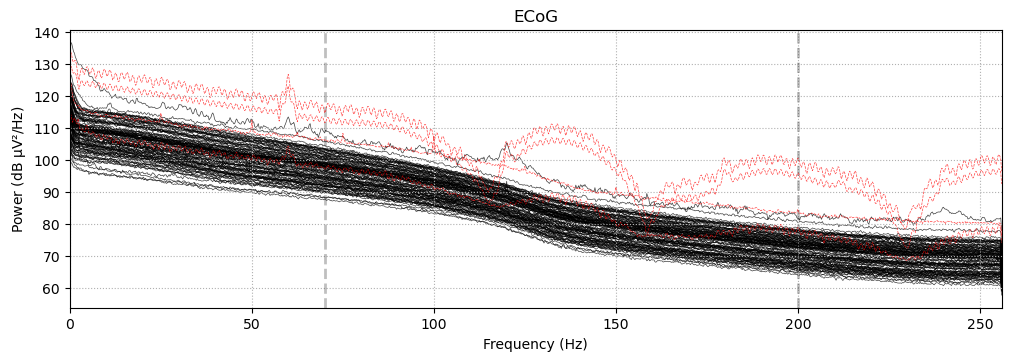

In [10]:
psd = raw.compute_psd(picks='ecog')
psd.plot()

Notice the outlier channels that exhibit periodic oscillations and deviate from the 1/f pattern the majority of the channels follow. We identified these electrodes by name from an previous analyses. Here, we will mark them as `bad` electrodes using the `Info` object.

In [6]:
raw.info['bads'] = ['DAMT1', 'DPMT4', 'DPMT6', 'DPMT7']
raw

<RawEDF | sub-01_task-podcast_ieeg.edf, 124 x 921600 (1800.0 s), ~98 kB, data not loaded>

## Common average re-referencing

Re-referencing is a common procedure applied to EEG and ECoG signals in order to remove common noise present across electrodes. This process simply averages all good channels together into one time series, and then subtracts the average from each channel. MNE implements this process in [set_eeg_reference](https://mne.tools/stable/generated/mne.io.Raw.html#mne.io.Raw.set_eeg_reference).

In [7]:
# Re-reference data
raw.load_data()  # required
rereferenced_raw = raw.set_eeg_reference(ref_channels="average", ch_type="ecog")

Reading 0 ... 921599  =      0.000 ...  1799.998 secs...
Applying average reference.
Applying a custom ('ECoG',) reference.


## Notch filter powerline noise

[Powerline noise](https://en.wikipedia.org/wiki/Utility_frequency) is an artifact in electrophysiology that comes from the line frequency of power from a utility (60 Hz in US, 50 Hz in other parts of the world). You can see the noise in the power spectrum above as sharp peaks at 60 Hz and its harmonics. We can easily remove these frequencies using a Notch filter using MNE:

In [8]:
# Notch filter power line noise
powerline_freq = raw.info.get("line_freq")
if powerline_freq is None:
    powerline_freq = 60
freqs = [powerline_freq * m for m in range(1, 4)]
notched_raw = rereferenced_raw.notch_filter(freqs=freqs, notch_widths=2)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 3381 samples (6.604 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    2.6s


## Frequency-band extraction

The signal so far is considered "cleaned" and ready for analyses. However, all other tutorials use the power modulations of the high gamma frequency band. This means we extract the signal with frequencies in the range 70–200 Hz, then apply a [hilbert transform](https://en.wikipedia.org/wiki/Hilbert_transform) to extract power modulation as the envelope of the analytic signal. Luckily, MNE implements these steps using the `filter` and `apply_hilbert` functions:

In [9]:
iir_params = dict(order=4, ftype="butter")
band_raw = notched_raw.filter(70, 200, picks="data", method="iir", iir_params=iir_params)
band_raw = band_raw.apply_hilbert(envelope=True)
band_raw

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 70 - 2e+02 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 70.00, 200.00 Hz: -6.02, -6.02 dB



<RawEDF | sub-01_task-podcast_ieeg.edf, 124 x 921600 (1800.0 s), ~872.0 MB, data loaded>